**Problem Statement** : Consumer Financial Protection Bureau(CFPB) is an agency of the United States government responsible for consumer protection in the financial sector. In their websites there are lots of bank related complaints are being raised and it becomes difficult to classify and send the complain to the respective department to handel it. So our aim is to classifiy or categogrise the complaints to a class so that further it can be resolved by the respective authorities.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re

from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
import tensorflow_hub as tf_hub
import gensim
from gensim.utils import simple_preprocess


In [2]:
data = pd.read_csv("https://github.com/krishna1711/MultiClass_Classification/blob/main/data.zip?raw=true",compression='zip', sep=',', quotechar='"')
data.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

## Data undertanding
* We will look at what data is

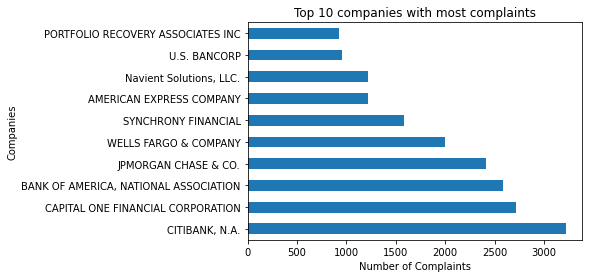

In [3]:
## lets top 10 which company has most complaints
data.Company.value_counts()[:10].plot(kind='barh')
plt.xlabel("Number of Complaints")
plt.ylabel('Companies')
plt.title("Top 10 companies with most complaints")
plt.show()

Text(0.5, 1.0, 'Complaint category(Product) Counts')

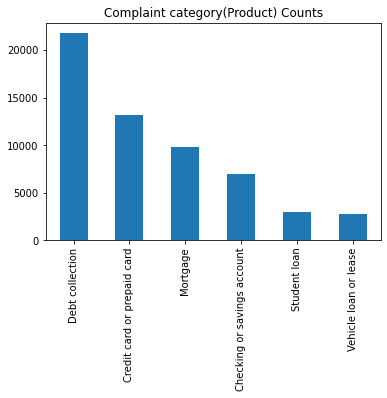

In [6]:
data['Product'].value_counts().plot(kind='bar')
plt.title("Complaint category(Product) Counts")

## As we are dealing with Classification of complaints
* We can only consider followng features
> * *'Consumer complaint narrative'* - independent feaure
> * *'Product'* - Dependent/Target feature

In [8]:
columns_required = ['Consumer complaint narrative','Product']
data_up = data[columns_required]
data_up.head()

,Consumer complaint narrative,Product
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account
4,This debt was incurred due to medical malpract...,Debt collection


In [9]:
## product map i.e used for label encoding
product_map = {val:idx for idx, val in enumerate(data_up['Product'].value_counts().index)}
product_map

{'Checking or savings account': 3,
 'Credit card or prepaid card': 1,
 'Debt collection': 0,
 'Mortgage': 2,
 'Student loan': 4,
 'Vehicle loan or lease': 5}

In [10]:
def split_data(data_up,trValtes_ratio):
  """
  Description: Converts the data frame into train, valid and test data
  Paramaters:
    data_up         : like Dataframe
    trValtes_ratio  : like list, example = [0.6,0.2,0.2] i.e train size, validation size and test size
  """
  trn_size, val_size, test_size = trValtes_ratio
  assert (trn_size + val_size + test_size == 1.0), "Make sure train,validtest ratios add up to 1.0"

  np.random.seed(2)
  trn_idx_e, val_idx_e = int(data_up.shape[0] * trn_size), int(data_up.shape[0] * val_size)
  random_space = np.random.permutation(len(data_up))
  trn_idxs, val_idxs, test_idxs =   random_space[:trn_idx_e], random_space[trn_idx_e:trn_idx_e+val_idx_e], random_space[trn_idx_e+val_idx_e:]
  train, valid, test = data_up.iloc[trn_idxs,:].copy(), data_up.iloc[val_idxs,:].copy(), data_up.iloc[test_idxs,:].copy()
  _,_,_ = train.reset_index(inplace=True, drop=True) , valid.reset_index(inplace=True, drop=True), test.reset_index(inplace=True, drop=True)
  return train,valid,test

The ratios we considered for Train,Valid and Test sets are
* Train    :    70%
* Valid    :    15%
* Test     :    15%

In [11]:
train,valid,test = split_data(data_up, [0.7,0.15,0.15])

* Lets look at the target variable and their categories before label encoding.
* This is just to ensure all categories are present.

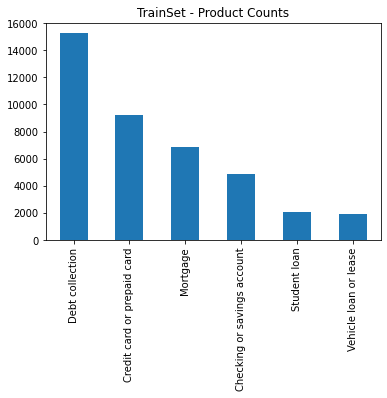

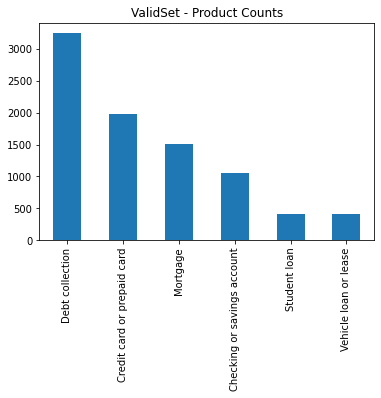

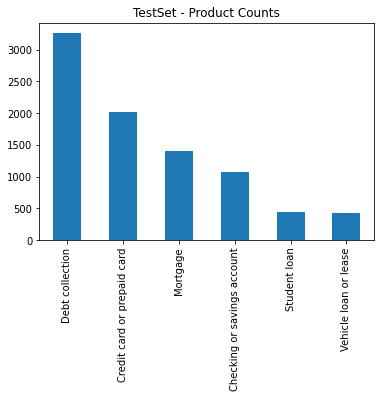

In [15]:
train['Product'].value_counts().plot(kind='bar')
plt.title("TrainSet - Product Counts")
plt.show()

valid['Product'].value_counts().plot(kind='bar')
plt.title("ValidSet - Product Counts")
plt.show()

test['Product'].value_counts().plot(kind='bar')
plt.title("TestSet - Product Counts")
plt.show()

In [16]:
# classweights = class_weight.compute_class_weight('balanced',
#                                   train['Product'].value_counts().index,
#                                   train['Product'])
# classweights_map = {product_map[cat]:weight for cat,weight in zip(train['Product'].value_counts().index,classweights)}
# classweights_map

In [17]:
## function to label encode
def label_encoding(data, feature_label, map_dict):
  data[feature_label] = data[feature_label].replace(map_dict)

In [18]:
## calling label_encoding 
label_encoding(train, 'Product', product_map)
label_encoding(valid, 'Product', product_map)
label_encoding(test, 'Product', product_map)

In [19]:
x_label = 'Consumer complaint narrative'
# train.columns

## Word Embbeddings

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk import word_tokenize,line_tokenize
from nltk.corpus import stopwords
import string

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stemmer = nltk.stem.SnowballStemmer('english')

def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer.fit_transform(train[x_label])

In [ ]:
## save the vectorizer
import _pickle as pickle
with open("/content/drive/MyDrive/pickle_dumps/customer_complaints_trained_vectorizer.pk", 'wb') as f:
  pickle.dump(vectorizer, f)

In [22]:
## transform valid and test set
x_train = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names())

valid_vectors = vectorizer.transform(valid[x_label])
x_valid = pd.DataFrame(valid_vectors.toarray(), columns=vectorizer.get_feature_names())

test_vectors = vectorizer.transform(test[x_label])
x_test = pd.DataFrame(test_vectors.toarray(), columns=vectorizer.get_feature_names())
x_test.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,...,vehicl,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.064257,0.0,0.0,0.0,0.039222,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091189,0.0,0.0,0.0,0.0,0.0,0.0,0.033476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028364,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058858,0.203107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075476,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.032931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.124494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.106078
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.035684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130309,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.057473


In [23]:
## just checking the shape after converting vectors to a dataframe
x_train.shape

(40217, 1000)

## Model Building
* We will be using a Nueral network

In [26]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(1000,)))
for units in [128, 64,64 ]:
  model.add(Dense(units, activation='relu'))
  model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.sparse_categorical_crossentropy(from_logits=True),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train.values,train['Product'].values,batch_size=128,epochs=5)

model.summary()


Epoch 1/5
315/315 [==============================] - 2s 5ms/step - loss: 1.0862 - accuracy: 0.5852
Epoch 2/5
315/315 [==============================] - 2s 5ms/step - loss: 0.4037 - accuracy: 0.8790
Epoch 3/5
315/315 [==============================] - 2s 5ms/step - loss: 0.3450 - accuracy: 0.8972
Epoch 4/5
315/315 [==============================] - 2s 5ms/step - loss: 0.2945 - accuracy: 0.9126
Epoch 5/5
315/315 [==============================] - 2s 5ms/step - loss: 0.2439 - accuracy: 0.9264
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_____________________

In [27]:
## Loss and Accuracy of Valid set
print("Valid dataset : loss and accuracy",model.evaluate(x_valid.values, valid['Product']))

270/270 [==============================] - 0s 1ms/step - loss: 0.3788 - accuracy: 0.8834
Valid dataset : loss and accuracy [0.3788177967071533, 0.8833701014518738]


In [28]:
## Identify the prediction values like which Product it falls under
y_valid_pred = model.predict(x_valid.values)
y_valid_pred = [np.argmax(pred) for pred in y_valid_pred]
y_valid_pred_products = [list(product_map)[idx] for idx in y_valid_pred]
## ets print some sample predictions
y_valid_pred_products[:5]

['Debt collection',
 'Debt collection',
 'Credit card or prepaid card',
 'Debt collection',
 'Checking or savings account']

## Classification Report
* In this we can analyse the Score for each category of **Product** feature
* We can understand what is its Recall, Precision etc.

In [29]:
## For Valid data
from sklearn.metrics import classification_report
print(classification_report(valid['Product'], y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3250
           1       0.84      0.88      0.86      1988
           2       0.91      0.94      0.92      1506
           3       0.86      0.86      0.86      1055
           4       0.85      0.79      0.82       410
           5       0.75      0.67      0.71       408

    accuracy                           0.88      8617
   macro avg       0.86      0.84      0.85      8617
weighted avg       0.88      0.88      0.88      8617



## Lets evaluate model on **TestData**
* This data has not been shown to the model until now, this is our final benchmarking

In [30]:
print("Test dataset : loss and accuracy",model.evaluate(x_test.values, test['Product']))

270/270 [==============================] - 0s 1ms/step - loss: 0.3878 - accuracy: 0.8810
Test dataset : loss and accuracy [0.3877700865268707, 0.8809606432914734]


In [31]:
y_test_pred = model.predict(x_test.values)
y_test_pred = [np.argmax(pred) for pred in y_test_pred]

print(classification_report(test['Product'], y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3262
           1       0.84      0.88      0.86      2017
           2       0.91      0.93      0.92      1405
           3       0.86      0.84      0.85      1072
           4       0.86      0.83      0.84       437
           5       0.73      0.68      0.70       426

    accuracy                           0.88      8619
   macro avg       0.85      0.84      0.85      8619
weighted avg       0.88      0.88      0.88      8619

